In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Promethee for the HDI dataset
First approach to applying PROMETHEE method to the HDI dataset (multivariate)

1. Read the dataset and transform it in the good format

In [ ]:
def transform_cols_in_sequence(data, col_id, range_of_years):
    cols = [col_id + year for year in range_of_years]

    # Transform col_id to remove "_"
    col_id = col_id.replace("_", "")

    # Add a new column named col_id (will be the sequence)
    data[col_id] = None

    for i, row in data.iterrows(): # For each row
        sequence = []
        for col in cols: # For each column
            sequence.append(row[col])
        sequence = np.array(sequence) # Transform the sequence into a numpy array
        data.at[i, col_id] = sequence # Replace the value of the new column with the sequence

    # Drop the columns that were transformed
    data = data.drop(columns=cols)

    return data

def read_data():
    PATH = "../data/HDI/HDR23-24_Composite_indices_complete_time_series.csv"
    data = pd.read_csv(PATH, encoding='latin1')
    data = data.dropna()

    years = [str(i) for i in range(1990, 2022)]

    fixed_col_names_to_keep = ['iso3', "hdi_rank_2022"]
    var_col_names_to_keep = ["co2_prod_", "pop_total_", "hdi_", "le_", "gdi_"]

    col_names_to_keep = fixed_col_names_to_keep + [var + year for var in var_col_names_to_keep for year in years]

    data = data[col_names_to_keep]

     # Transform the variable columns into sequences
    for col in var_col_names_to_keep: 
        data = transform_cols_in_sequence(data, col, years)

    return data


data = read_data()
data

In [ ]:
def plot_data(data):
    """ 
    For each column, plot a graph with one color per row (country in this case)
    On the x-axis, the years (1990-2022)
    Using subplots
    """
    Nb_cols = len(data.columns) - 2
    fig, axs = plt.subplots(Nb_cols, 1, figsize=(10, 20))

    for i, col in enumerate(data.columns[2:]):
        for j, row in data.iterrows():
            axs[i].plot(row[col], label=row["iso3"])
        axs[i].set_title(col)
    plt.show()

# plot_data(data)
    

In [28]:
def scale_column(data, col):
    """
    Scale a column between 0 and 1 knowing that each row is a sequence np.array
    Scaling using the min and max of the column and not of the sequence each time!
    """
    min_val = data[col].apply(lambda x: x.min()).min()
    max_val = data[col].apply(lambda x: x.max()).max()
    data[col] = data[col].apply(lambda x: (x - min_val) / (max_val - min_val))
    return data

def scale_data(data):
    """
    Scale all the columns that are sequences
    """
    for col in data.columns[2:]:
        data = scale_column(data, col)
    return data

data = scale_data(data)

## 2. Applying Promethee
Now that the Data is scaled and in the correct format, let's apply PROMETHEE. Let's define the functions that will be needed:
- Difference between two time series `d_ab`
- The Information within criterion $P_j(a,b)$ (here let's do a simple linear one)
- The Aggregated preference $\Pi(a,b)$



In [32]:
K = len(data.columns) - 2 # 5
N = len(data)
P = [0.9, 0.9, 0.9, 0.9, 0.9] # Preference parameters
Q = [-0.1, -0.1, -0.1, -0.1, -0.1] # Indifference parameters
W = [0.2, 0.2, 0.2,0.2,0.2] # Weights

def d_ab(t1, t2):
    """ 
        Difference between two time series
        Parameters:
            t1: np.array
            t2: np.array
        Returns:
            np.array
    """
    return t1 - t2

def Pj_ab_linear(t1, t2, c):
    """ 
        Pj(a,b) for criteria k=c
        t1, t2: time series (one criteria)
        c: index of the criteria for the pref/indif threshold
        Returns the value of the preference function for this criteria
    """
    d = d_ab(t1, t2)
    for i in range(len(d)):
        if d[i] <= Q[c]:
            d[i] = 0
        elif d[i] > P[c]:
            d[i] = 1
        else:
            d[i] = (d[i] - Q[c]) / (P[c] - Q[c])
    return d

def PI_ab(t1, t2):
    """ 
        PI(a,b) for two time series
        t1, t2: rows of the data (two countries in this case)
        Returns the value of the preference function for the two time series
    """
    cols = t1.index[2:] # Get the columns that are sequences (criteria)
    res = 0
    for c in range(K):
        res += W[c] * Pj_ab_linear(t1[cols[c]], t2[cols[c]], c)
    return res

In [35]:
row1 = data.iloc[0]
row2 = data.iloc[1]

print(PI_ab(row1, row2))
print(PI_ab(row2, row1))


[0.39504682 0.40965987 0.38229018 0.37869231 0.37228879 0.36293946
 0.3660299  0.34972988 0.33268015 0.32126042 0.31953806 0.31829336
 0.31615153 0.3251108  0.32906611 0.32599219 0.33347954 0.32879092
 0.33318472 0.32482064 0.31220747 0.31149859 0.30536173 0.29469219
 0.29433059 0.28598672 0.27008202 0.26327575 0.25666627 0.24765926
 0.23385179 0.2304661 ]
[0.03060987 0.03084155 0.03106465 0.03130497 0.03155198 0.03179705
 0.03203062 0.03227778 0.03254748 0.03283006 0.03311781 0.0334122
 0.03370622 0.03398678 0.03425674 0.03450183 0.03468835 0.0348461
 0.03497251 0.03509709 0.03527773 0.03547697 0.03568316 0.03589727
 0.0361102  0.03631464 0.03653441 0.03676552 0.03698353 0.03719717
 0.03742703 0.04227662]


In [ ]:
def PI_matrix(data):
    """ 
        Compute a matrix of size NxN where N is the number of rows in the data
        The matrix will contain the PI_ab sequence of values for each pair of rows
            - PI_matrix[i][j] will contain the PI_ab value for the rows i and j
            - PI_matrix[i][i] will contain a series of 0
    """
    size_of_sequence = data.iloc[1][3].shape[0]
    # PI matrix is a matrix of sequences of size
    PI_matrix = np.zeros((N, N, size_of_sequence))
    for i in range(N):
        for j in range(N):
            if i != j: # If the two rows are different as if i=j, PI_ab = 0
                PI_matrix[i][j] = PI_ab(data.iloc[i], data.iloc[j]) # i is the row
    return PI_matrix

PI_mat= PI_matrix(data)

C:\Users\raphu\AppData\Local\Temp\ipykernel_4276\1649124254.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_of_sequence = data.iloc[1][3].shape[0]


In [47]:
def POS_PHI(PI_mat):
    """
        Compute the POS_PHI list, which is a list of N elements
        Positive flow = sum columns in an horizontal way
        POS_PHI[i] = 1/(N-1)  sum(PI_mat[i][j]) for j in range(N) # j is the column s
    """
    return PI_mat.sum(axis=1)/(N-1)

def NEG_PHI(PI_mat):
    """
        Compute the NEG_PHI list, which is a list of N elements
        Negative flow = sum rows in a vertical way
        NEG_PHI[i] = 1/(N-1) sum(PI_mat[j][i]) for j in range(N) # j is the row
    """
    return PI_mat.sum(axis=0)/(N-1)

POS_PHI_mat = POS_PHI(PI_mat)
NEG_PHI_mat = NEG_PHI(PI_mat)

def PHI(POS_PHI_mat, NEG_PHI_mat):
    """
        Compute the PHI list, which is a list of N elements
        PHI[i] = POS_PHI[i] - NEG_PHI[i]
    """
    return POS_PHI_mat - NEG_PHI_mat

NET_FLOW = PHI(POS_PHI_mat, NEG_PHI_mat)    

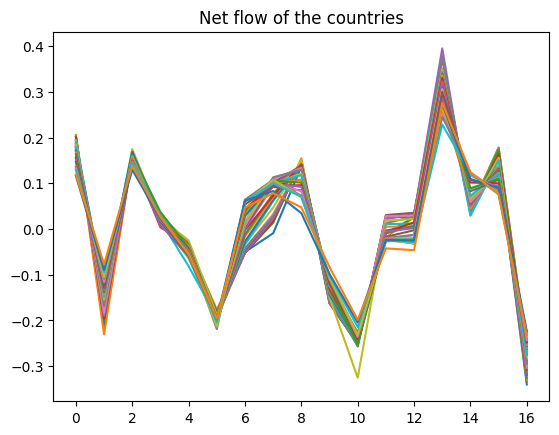

In [50]:
# Plot net flows of the countries
plt.plot(NET_FLOW)
plt.title("Net flow of the countries")
plt.show()